In [2]:
from graph_tool.all import *
from numba import jit
from numba.types import int64
from numba import njit, prange
from numba import jit, njit
from numba.types import float64, int64
from numba import njit, prange
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mpc1oi65 because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# functions

## FUNCTIONS

def filter_by_location(np_array):
    
    # Sort input array test w.r.t. first column that are IDs
    test_sorted = np_array[np_array[:,1].argsort()]

    # Convert the string IDs to numeric IDs
    locations = np.unique(test_sorted[:,1], return_inverse=False)
    # print('shape of numeric_ID {}'.format(numeric_ID.shape))

    # Get the indices where shifts (IDs change) occur
    _,cut_idx = np.unique(test_sorted[:,1],return_index=True)

    # Use the indices to split the input array into sub-arrays with common IDs
    return np.split(test_sorted,cut_idx)[1:]

@njit
def get_contact_per_location(test_case, parameters, w=None, purpose=None, locsize=10):
    
    # ID - LOCATION - START TIME - END TIME / PURPOSE
    
    edge_list=[]
    #threshold=.012550110735619152
    #w=6.95002417897531
    #threshold=w/(w+locsize-2)
    #threshold=0.012550110735619152
    #act=np.array([[0,  5,  6,  8,  11],
    #               [5,  1,  7,  9,  12],
    #               [6,  7,  2, 10,  13],
    #               [8,  9, 10,  3,  14],
    #               [11,12, 13, 14,   4]])
    
    
    act=np.array([[0,  3,  4],
                  [3,  1,  5],
                  [4,  5,  2]])

    
    #threshold=np.array([[0.00612023, 0.02394995, 0.20427608],
    #   [0.02394995, 0.02013064, 0.        ],
    #   [0.20427608, 0.        , 0.10465638]])
    
    #threshold=0.02
        
    for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
        row=test_case[i]
        pu=purpose[i] # origin
        
        rem=test_case[(i+1):]
        
        for k, pv in zip(rem, purpose[(i+1):]):  
            if k[0]!=row[0]: # if individuals are different
                
                if row[-1]<=k[2]: # no intersection
                    break
                
                
                if pu>1:
                    pu=2
                
                if pv>1:
                    pv=2
                
                
                if w!=None:
                    threshold=w[pu,pv]/(w[pu,pv]+locsize-2)
                else:
                    threshold=parameters[pu, pv]
                    
                # threshold=1.
                    
                if np.random.uniform(0,1,1)[0]<=threshold:
                #if np.random.uniform(0,1,1)[0]<=threshold[pu,pv]:
                    if row[-1]<k[-1]:
                        d=row[-1]-k[2]
                        #edge_list.append((row[0], k[0], d, act[pu, pv], row[1]))
                    else:
                        d=k[-1]-k[2]
                        
                    edge_list.append((row[0], k[0], d, act[pu, pv], row[1]))

    return edge_list

@njit
def get_properties_potential_contact_network(test_case, purpose=None):
    
    # ID - LOCATION - START TIME - END TIME / PURPOSE
     
    act=np.zeros((3, 3))
    number_of_contacts_per_location=0
        
    for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
        row=test_case[i]
        pu=purpose[i] # origin
        
        rem=test_case[(i+1):]
        
        for k, pv in zip(rem, purpose[(i+1):]):  
            if k[0]!=row[0]: # if individuals are different
                
                if row[-1]<=k[2]: # no intersection
                    break
                else:
                    if pu>2:
                        pu=2
                
                    if pv>2:
                        pv=2
                        
                    act[pu, pv]+=1
                    number_of_contacts_per_location+=1

    return act, number_of_contacts_per_location

# This function helps me to check which agent is involved in a layer, and the number of occurences. This will be useful to compute the expected value of contacts by layer

@njit
def get_status(n, out):
    status_layer=np.zeros((n, 5))
    for k in out:
        for l in k:
            status_layer[l[0],l[-1]]+=1
    return status_layer




def get_contacts_fast_2(G, attr1=None):
    e=G.get_edges()
    v=G.get_vertices(vprops=[G.vp['age']])

    acp=np.vstack((v[e[:,0],1],v[e[:,1],1])).T
    #twins=acp[acp[:,0]==acp[:,1]]
    #others=acp[acp[:,0]!=acp[:,1]]

    
    #return np.vstack((twins,others,others[:,[1,0]]))
    return acp

In [4]:
## DATA PRE-PROCESSING

#df_persons=pd.read_csv('data/all/egt/persons.csv',';').drop(['Unnamed: 0'], axis=1)
#df_persons['person_id_gt']=df_persons.index

df_persons=pd.read_csv('./raw-updated-sampled-p/people.csv',',')#.drop(['Unnamed: 0'], axis=1)
print(df_persons.head())
#df_persons=pd.read_csv('./raw-updated-sampled-p/persons.csv',',').drop(['Unnamed: 0'], axis=1)
df_persons['person_id_gt_s']=df_persons.index

npop=df_persons.shape[0]

# print(df_persons.shape, '//', df_persons['person_id_gt_s'].max())

df_homes=pd.read_csv('./raw-updated-sampled-p/households.csv',',')#.drop(['Unnamed: 0'], axis=1)
df_persons=df_persons.merge(df_homes[['hid','hinsee']], on='hid', how='left')

fcontacts=pd.read_csv('sampled.csv')
df_persons=df_persons.merge(fcontacts, left_on='person_id_gt', right_on='person_id')

   pid  hid  freq      hzone  age  employed     sex  socioprofessional_class  \
0   36   11   NaN  1007655.0   37     False    male                        6   
1  132   61   NaN   812128.0   46      True    male                        3   
2  194  106   NaN   936527.0   25      True    male                        3   
3  253  139   NaN   978041.0   50     False  female                        4   
4  277  150   NaN   601402.0   39      True    male                        4   

   has_driving_license  has_pt_subscription  census_person_id  hts_id  \
0                 True                False                15    8798   
1                False                 True                50   19871   
2                False                False                74     739   
3                 True                False                96     561   
4                False                False               106   16880   

   person_id_gt  
0        159047  
1        463827  
2        587408  
3       

In [5]:
#df_persons=pd.read_csv('./raw-updated-sampled-p/people.csv',',')#.drop(['Unnamed: 0'], axis=1)
sum(df_persons['person_id_gt'].isin([2604967]))

1

In [6]:
from itertools import combinations


def compute_potential_network_properties(out):
    ## PROPERTIES OF THE POTENTIAL CONTACT NETWORK

    list_of_group_contacts=[] # To store the amount of contacts generated after filtering per space/time at location ID k
    list_of_adjacency_matrices=[]
    nbloc=0

    sttm=time.time()

    loop_over=out

    with tqdm(total=len(loop_over), position=0, leave=True) as pbar: 
        for k in loop_over:
            if k[0,1]>-1:
                locsize=len(np.unique(k[:,0]))
                if locsize>1:
                    k_sorted=k[k[:, 2].argsort()]
                    fo, nb_cnts=get_properties_potential_contact_network(k_sorted[:,0:-1], k_sorted[:,-1])
                    list_of_group_contacts.append((locsize, nb_cnts))
                    list_of_adjacency_matrices.append(fo)
                    nbloc+=1
            pbar.update(1)

    #print(time.time()-sttm)
    return list_of_group_contacts, list_of_adjacency_matrices  

@njit
def get_status(n, out):
    status_layer=np.zeros((n, 5))
    for k in out:
        for l in k:
            status_layer[l[0],l[-1]]+=1
    return status_layer


def get_list_of_contacts_in_HH(df_persons):
    list_of_contacts_in_HH=[]

    with tqdm(total=len(df_persons['hid'].unique()), position=0, leave=True) as pbar: 
        for k in df_persons[['hid','person_id_gt_s']].groupby('hid'):
            if k[1].shape[0]>1:
                list_of_contacts_in_HH.extend(list(combinations(k[1]['person_id_gt_s'], 2)))

            pbar.update(1)
    return list_of_contacts_in_HH

def get_list_of_contacts_in_CC(out): 

    w=None
#     parameters=np.array([[0.0048184 , 0.0207169 , 0.16349478],
#                          [0.0207169 , 0.02147339, 0.        ],
#                          [0.16349478, 0.        , 0.10746673]])
    
    parameters=np.array([[0.00812529, 0.02311313, 0.10027465],
                         [0.02311313, 0.03710119, 0.        ],
                         [0.10027465,         0., 0.15547149]])


    #list_of_group_contacts=[] # To store the amount of contacts generated after filtering per space/time at location ID k
    list_of_contacts=[]

    sttm=time.time()

    loop_over=out

    with tqdm(total=len(loop_over), position=0, leave=True) as pbar: 
        for k in loop_over:
            if k.shape[0]>1:
                k_sorted=k[k[:, 2].argsort()]
                fo=get_contact_per_location(k_sorted[:,0:-1], parameters, w, k_sorted[:,-1], len(np.unique(k_sorted[:,0])))
                #list_of_group_contacts.append((len(np.unique(k_sorted[:,0])), len(fo))) # n_ij and E_ij
                list_of_contacts.extend(fo)
            pbar.update(1)

    #print(time.time()-sttm)
    return list_of_contacts

def to_HHcontact_network(df_persons, list_of_contacts_in_HH):

    # COMBINING HOUSEHOLD AND NON-HOUSEHOLD CONTACTS
    # Add household-based contacts !

    #graph_household=load_graph('files/graph_weekday_household_all.xml.gz')

    graph_household=Graph(directed=False)
    graph_household.add_vertex(df_persons.shape[0])

    graph_household.vp['age'] = graph_household.new_vp('int', vals=df_persons.age.values.astype(int), val=None)
    #graph_household.vp['dep'] = graph_household.new_vp('int', vals=df_persons.numdep.values.astype(int), val=None)
    graph_household.vp['insee'] = graph_household.new_vp('int', vals=df_persons.hinsee.values.astype(int), val=None)

    graph_household.add_edge_list(list_of_contacts_in_HH)

    graph_household.edge_properties['p'] = graph_household.new_ep('int', vals=None, val=2000000)
    graph_household.edge_properties['purpose'] = graph_household.new_ep('int', vals=None, val=6)
    graph_household.edge_properties['duration'] = graph_household.new_ep('int', vals=None, val=-1)
    
    return graph_household

def to_CCcontact_network(df_persons, list_of_CCcontacts, list_of_HHcontacts=None):     
    ## BUILD PHYSICAL CONTACT NETWORK
    # Here I build my contact network based on the list of edges previously computed

    print('Creating an undirected contact network of size ', df_persons.shape[0], ' nodes ...')

    start_time=time.time()

    setting_temporal_network=Graph(directed=False)
    setting_temporal_network.add_vertex(df_persons.shape[0])

    setting_temporal_network.vp['age'] = setting_temporal_network.new_vp('int', vals=df_persons.age.values.astype(int), val=None)
    #setting_temporal_network.vp['dep'] = setting_temporal_network.new_vp('int', vals=df_persons.numdep.values.astype(int), val=None)
    setting_temporal_network.vp['insee'] = setting_temporal_network.new_vp('int', vals=df_persons['hinsee'].values.astype(int), val=None)
    setting_temporal_network.vp['id'] = setting_temporal_network.new_vp('int', vals=df_persons['person_id_gt'].values.astype(int), val=None)
    
    ppid = setting_temporal_network.new_ep('int')
    purpose = setting_temporal_network.new_ep('int')
    dur = setting_temporal_network.new_ep('int')

    #ppis = setting_temporal_network.new_ep('int')

    setting_temporal_network.edge_properties['duration'] = dur
    setting_temporal_network.edge_properties['purpose'] = purpose
    setting_temporal_network.edge_properties['p'] = ppid

    #setting_temporal_network.edge_properties['n'] = ppis

    print('Adding links ...')
    setting_temporal_network.add_edge_list(list_of_CCcontacts, eprops=[dur, purpose, ppid])

    print('contact network has {} egdes and {} vertices'.format(setting_temporal_network.num_edges(), setting_temporal_network.num_vertices()))
    print('Setting-based contact network estimated in ',time.time()-start_time, ' secs !')

    # setting_temporal_network.save("files/graph_weekday_complete.xml.gz")
    
    setting_temporal_network.add_edge_list(list_of_HHcontacts, eprops=[dur, purpose, ppid])
        
    return setting_temporal_network
        
def clean_df(df_activities):
    
    row={'person_id': np.nan,
     'hid': np.nan,
     'freq': np.nan,
     'purpose': 'education',
     'seq': np.nan,
     'start_time': np.nan,
     'end_time': np.nan,
     'duration':np.nan ,
     'location_id':np.nan }
    
    df_activities=df_activities.rename(columns={'activity': 'purpose', 'start time': 'start_time', 'end time': 'end_time', 'pid':'person_id', 'zone': 'location_id'})

    df_activities=df_activities[df_activities['purpose']!='home']
    df_activities=df_activities[(~df_activities.start_time.isnull())&(~df_activities.end_time.isnull())]
    df_activities=df_activities.append(row, ignore_index=True)


    #print(df_activities['purpose'].value_counts())
    df_activities['purpose']=df_activities['purpose'].astype('category').cat.reorder_categories(['work', 'education', 'leisure', 'shop', 'other']).cat.codes
    df_activities = df_activities.iloc[:-1 , :]
    #print(df_activities['purpose'].value_counts())


    df_activities=df_activities.merge(df_persons[['person_id_gt_s', 'pid','age']], left_on='person_id', right_on='pid')
    df_activities=df_activities[~df_activities['location_id'].isin([-1])]
    df_activities['end_time']=df_activities['end_time'].replace([0, -1],24*3600)
    
    f=(df_activities['end_time']-df_activities['start_time'])<0
    A=df_activities[f]
    df_activities.loc[f,'end_time']=A['start_time']+A['end_time']
    #df_activities.loc[f,'end_time']=A['end_time']
    
    return df_activities

def clean_df_2(df_activities):
    
    row={'person_id': np.nan,
     'hid': np.nan,
     'freq': np.nan,
     'purpose': 'education',
     'seq': np.nan,
     'start_time': np.nan,
     'end_time': np.nan,
     'duration':np.nan ,
     'location_id':np.nan }
    
    df_activities=df_activities.rename(columns={'pid':'person_id', 'location': 'location_id'})

    df_activities=df_activities[df_activities['purpose']!='home']
    df_activities=df_activities[(~df_activities.start_time.isnull())&(~df_activities.end_time.isnull())]
    df_activities=df_activities.append(row, ignore_index=True)


    #print(df_activities['purpose'].value_counts())
    df_activities['purpose']=df_activities['purpose'].astype('category').cat.reorder_categories(['work', 'education', 'leisure', 'shop', 'other']).cat.codes
    df_activities = df_activities.iloc[:-1 , :]
    #print(df_activities['purpose'].value_counts())


    df_activities=df_activities.merge(df_persons[['person_id_gt_s', 'pid','age']], left_on='person_id', right_on='pid')
    df_activities=df_activities[~df_activities['location_id'].isin([-1])]
    df_activities['end_time']=df_activities['end_time'].replace([0, -1],24*3600)
    
    f=(df_activities['end_time']-df_activities['start_time'])<0
    A=df_activities[f]
    df_activities.loc[f,'end_time']=A['start_time']+A['end_time']
    #df_activities.loc[f,'end_time']=A['end_time']
    
    return df_activities

def light_clean_df(df_activities, df_persons):
    df_activities=df_activities[df_activities['purpose']!='home']
    df_activities=df_activities[(~df_activities.start_time.isnull())&(~df_activities.end_time.isnull())]
    df_activities['purpose']=df_activities['purpose'].astype('category').cat.reorder_categories(['work', 'education', 'leisure', 'shop', 'other']).cat.codes
    df_activities=df_activities.merge(df_persons[['person_id_gt_s', 'pid','age']], on='pid')
    df_activities=df_activities.rename(columns={'pid':'person_id', 'location': 'location_id'})
    df_activities=df_activities[~df_activities['location_id'].isin([-1])]
    return df_activities 



In [7]:
# scn1=load_graph('sampled_contact_network_22_08_2022.xml.gz')
scn1=load_graph('sampled_contact_network_22_08_2022.xml.gz')

In [8]:
# row={'person_id': np.nan,
#      'hid': np.nan,
#      'freq': np.nan,
#      'purpose': 'education',
#      'seq': np.nan,
#      'start_time': np.nan,
#      'end_time': np.nan,
#      'duration':np.nan ,
#      'location_id':np.nan }

# # ref
df_activities_ref=pd.read_csv('./raw-updated-sampled-p/activities.csv')
df_activities_ref.head()
df_activities_ref=light_clean_df(df_activities_ref, df_persons)


# #.drop(['Unnamed: 0'], axis=1).rename(columns={'uid':'location_id'})

# # policy
# df_activities=pd.read_csv('./raw-updated-sampled-p/activities.csv')
# #.drop(['Unnamed: 0'], axis=1).rename(columns={'uid':'location_id'})

# df_activities1=pd.read_csv('./raw-updated-sampled-p/activities1.csv')
# ########

# df_activities2=pd.read_csv('./raw-updated-sampled-p/activities2.csv')

# df_activities2=light_clean_df(df_activities2, df_persons)
# df_activities1=light_clean_df(df_activities1, df_persons)
# df_activities=light_clean_df(df_activities, df_persons)
# df_activities_ref=light_clean_df(df_activities_ref, df_persons)

# df=[df_activities_ref, df_activities, df_activities1, df_activities2]

In [9]:
df_persons.head()

,pid,hid,freq,hzone,age,employed,sex,socioprofessional_class,has_driving_license,has_pt_subscription,census_person_id,hts_id,person_id_gt,person_id_gt_s,hinsee,person_id,full_contacts
0,36,11,NaN,1007655.0,37,False,male,6,True,False,15,8798,159047,0,75112.0,159047,0
1,132,61,NaN,812128.0,46,True,male,3,False,True,50,19871,463827,1,75102.0,463827,0
2,194,106,NaN,936527.0,25,True,male,3,False,False,74,739,587408,2,75111.0,587408,0
3,253,139,NaN,978041.0,50,False,female,4,True,False,96,561,784357,3,75120.0,784357,0
4,277,150,NaN,601402.0,39,True,male,4,False,False,106,16880,855505,4,75116.0,855505,0


In [10]:
df_activities_ref.head()

,hid,person_id,purpose,start_time,end_time,location_id,person_id_gt_s,age
0,11,36,3,34680,38280,938383,0,37
1,11,36,3,40680,41280,1028240,0,37
2,11,36,3,41580,41580,999979,0,37
3,11,36,2,42480,44280,1089543,0,37
4,11,36,4,52680,52680,1211255,0,37


In [11]:
# pd.read_csv('./raw-updated-sampled-p/activities_1.0.csv')

In [12]:
list_of_df_activties=[]
list_of_df_activties.append(df_activities_ref)


# work from home
for k in np.linspace(0,1,5)[1:-1]:
    df=light_clean_df(pd.read_csv('./raw-updated-sampled-p/activities_'+str(k)+'.csv'), df_persons)
    list_of_df_activties.append(df)
    
    
# school closure
# for k in np.linspace(0,1,5)[1:-1]:
#     df=light_clean_df(pd.read_csv('./raw-updated-sampled-p/activities_'+str(k)+'_sc.csv'), df_persons)
#     list_of_df_activties.append(df)

# group dataframes
df=list_of_df_activties

In [36]:
df[1]

,hid,person_id,purpose,start_time,end_time,location_id,person_id_gt_s,age
0,11,36,3,34680,38280,938383,0,37
1,11,36,3,40680,41280,1028240,0,37
2,11,36,3,41580,41580,999979,0,37
3,11,36,2,42480,44280,1089543,0,37
4,11,36,4,52680,52680,1211255,0,37
...,...,...,...,...,...,...,...,...
656606,5139476,11671762,2,74280,86400,530401,235169,44
656607,5179985,11712271,1,46140,70140,1073834,235170,26
656608,5179985,11712271,2,71940,86400,1248772,235170,26
656609,5211865,11744151,1,43080,67080,390565,235171,18


In [13]:
# df_activities_ref_full=pd.read_csv('./raw-updated/activities.csv')

In [14]:
# df_persons.merge(fcontacts, left_on='pid', right_on='person_id')

In [15]:
fcontacts=pd.read_csv('sampled.csv')
fcontacts.head()

,person_id,full_contacts
0,293,0
1,294,1
2,370,0
3,610,0
4,659,0


In [16]:
# This function returns (1) list_of_group_contacts and (2) list_of_adjacency_matrices
def get_contact_objects(df, npop):

    ## Compute list of contacts
    out=filter_by_location(df[['person_id_gt_s','location_id','start_time','end_time','purpose']].astype(int).values)
    status_layer=get_status(npop, out)
    a, b=compute_potential_network_properties(out)

    return a, b, np.count_nonzero(status_layer, axis=0)

# This function aggregates (2) the list_of_adjacency_matrices 
def aggregate_adjacency_matrices(list_of_adjacency_matrices):
    E_potential=np.zeros((3,3))

    for k in list_of_adjacency_matrices:
        E_potential+=k
    return E_potential

/usr/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'out' of function 'get_status'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-edc37211d259>", line 31:
@njit
def get_status(n, out):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
100%|██████████| 127023/127023 [00:01<00:00, 67343.56it/s]


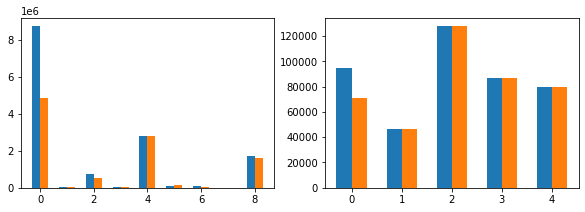

In [17]:
list_of_group_contacts, list_of_adjacency_matrices, number_of_agents_by_layer_ref  =get_contact_objects(df_activities_ref, npop)
TAB_ref=aggregate_adjacency_matrices(list_of_adjacency_matrices)

width=0.3

ncols=2
scale=1.25
fig, (ax, ax2)=plt.subplots(ncols=ncols, figsize=(4*ncols*scale, 2.5*scale))
ax.bar(np.arange(9)-width/2, TAB_ref.reshape(-1), width)
ax2.bar(np.arange(5)-width/2, number_of_agents_by_layer_ref, width)

list_of_group_contacts, list_of_adjacency_matrices, number_of_agents_by_layer_pol  =get_contact_objects(df[1], npop)
TAB_pol=aggregate_adjacency_matrices(list_of_adjacency_matrices)
ax.bar(np.arange(9)+width/2, TAB_pol.reshape(-1), width)
ax2.bar(np.arange(5)+width/2, number_of_agents_by_layer_pol, width)


plt.show()

In [18]:
a,b=np.unique(scn1.ep['purpose'].a, return_counts=True)
TAB_ref_eff=np.zeros((3,3))
store=np.array([[0,0],[1,1],[2,2],[0,1],[0,2]])
for k, value in zip(store, b):
    TAB_ref_eff[k[0], k[1]]=value

def aggregate(A, n):
    B=np.zeros((n,n))
    #B[0:(n-1),0:(n-1)]=(np.tril(A, k=-1).T+np.triu(A, k=0))[0:(n-1),0:(n-1)]
    #B[(n-1),(n-1)]=(np.tril(A, k=-1).T+np.triu(A, k=0))[(n-1):,(n-1):].sum()
    #B[:,(n-1)]=(np.tril(A, k=-1).T+np.triu(A, k=0))[:n,(n-1):].sum(axis=1)
    
    B[:(n-1),:(n-1)]=A[:(n-1),:(n-1)]
    B[(n-1),(n-1)]=A[(n-1):,(n-1):].sum()
    B[(n-1),:(n-1)]=A[(n-1):,:(n-1)].sum(axis=0)
    B[:(n-1),(n-1)]=A[:(n-1),(n-1):].sum(axis=1)
    
    return np.tril(B, k=-1).T+np.triu(B, k=0)

parameters=TAB_ref_eff/aggregate(TAB_ref, 3)
parameters

<ipython-input-18-bec0b4cb4247>:20: RuntimeWarning: invalid value encountered in true_divide
  parameters=TAB_ref_eff/aggregate(TAB_ref, 3)


array([[0.01283388, 0.10780243, 0.1532186 ],
       [       nan, 0.0147795 , 0.        ],
       [       nan,        nan, 0.12848559]])

In [19]:
aggregate(TAB_ref, 3).sum()

14324531.0

In [20]:
list_of_contacts_in_HH=get_list_of_contacts_in_HH(df_persons)
graph_household=to_HHcontact_network(df_persons, list_of_contacts_in_HH)

mu_HH=graph_household.num_edges()*2/graph_household.num_vertices()

100%|██████████| 183576/183576 [00:06<00:00, 26511.89it/s]


In [21]:
# # Calibration model

# mu_potential_ref_WW=(2*TAB_ref[0,0]+TAB_ref[0, 1:].sum())/number_of_agents_by_layer_ref[0]
# mu_potential_ref_EE=(2*TAB_ref[1,1]+TAB_ref[1, 0]+TAB_ref[1, 2])/number_of_agents_by_layer_ref[1]
# mu_potential_ref_XX=(2*TAB_ref[2,2]+TAB_ref[2,:-1].sum())/number_of_agents_by_layer_ref[2:].sum()


# mu_potential_pol_WW=(2*TAB_pol[0,0]+TAB_pol[0, 1:].sum())/number_of_agents_by_layer_pol[0]
# mu_potential_pol_EE=(2*TAB_pol[1,1]+TAB_pol[1, 0]+TAB_pol[1, 2])/number_of_agents_by_layer_pol[1]
# mu_potential_pol_XX=(2*TAB_pol[2,2]+TAB_pol[2,:-1].sum())/number_of_agents_by_layer_pol[2:].sum()

# mu_eff_ref_WW=3.14*2.11
# mu_eff_ref_EE=1.55*2.11
# mu_eff_ref_XX=1.*2.11

# mu_eff_pol_WW=mu_eff_ref_WW*(mu_potential_pol_WW/mu_potential_ref_WW)
# mu_eff_pol_EE=mu_eff_ref_EE*(mu_potential_pol_EE/mu_potential_ref_EE)
# mu_eff_pol_XX=mu_eff_ref_XX*(mu_potential_pol_XX/mu_potential_ref_XX)


# ######


# # Calcul de p_EE

# list_of_contacts_in_HH=get_list_of_contacts_in_HH(df_persons)
# graph_household=to_HHcontact_network(df_persons, list_of_contacts_in_HH)

# mu_HH=graph_household.num_edges()*2/graph_household.num_vertices()
# mu_EE=1.55*mu_HH*2.5
# #mu_WW=3.17*2.11
# mu_WW=3.17*mu_HH

# #pi_EE=0.97
# pi_EE=0.97 # socio-patterns

# p_EE=(pi_EE*mu_EE*number_of_agents_by_layer[1])/(2*E[1,1])
# p_EE

# p_EW=((1-pi_EE)*mu_EE*number_of_agents_by_layer[1])/E[0,1]
# p_EW

# p_EX=0 # by assumption

# # pi_WW=0.9 because by averaging all the pi_WW_j where j is individual j

# p_WW=(.9*mu_WW*number_of_agents_by_layer[0])/(2*E[0,0])
# p_WW

# p_WX=(mu_WW*number_of_agents_by_layer[0]-2*E[0,0]*p_WW-E[0,1]*p_EW)/E[0,2]
# p_WX


# # daily average number of contacts is 10 by assumption
# #(10*graph_household.num_vertices()/2-graph_household.num_edges())/E.sum()
# p0=(10*df_persons.shape[0]/2-len(list_of_contacts_in_HH))/E.sum()


# # by using the general equation
# p_XX=(p0*E.sum()
#       -E[0,0]*p_WW
#       -E[1,1]*p_EE
#       -E[0,1]*p_EW
#       -E[0,2]*p_WX
#       -E[1,2]*p_EX)/E[2,2]
# p_XX

# parameters=np.array([[p_WW, p_EW, p_WX],
#           [p_EW, p_EE, p_EX],
#           [p_WX, p_EX, p_XX]])

# print(parameters>=0)
# print(parameters<=1)

In [23]:
#mu_eff_pol_XX

In [24]:
#mu_eff_ref_XX

In [26]:
# This function returns (1) list_of_group_contacts and (2) list_of_adjacency_matrices
def run(df, df_persons):

    out=filter_by_location(df[['person_id_gt_s','location_id','start_time','end_time','purpose']].astype(int).values)

    list_of_contacts_in_HH=get_list_of_contacts_in_HH(df_persons)
    list_of_CCcontacts=get_list_of_contacts_in_CC(out)

    # to_HHcontact_network(df_persons, list_of_contacts_in_HH)
    G= to_CCcontact_network(df_persons, list_of_CCcontacts, list_of_HHcontacts=list_of_contacts_in_HH)
    
    return G



100%|██████████| 129789/129789 [00:04<00:00, 32153.68it/s]


Creating an undirected contact network of size  235172  nodes ...
Adding links ...
contact network has 524574 egdes and 235172 vertices
Setting-based contact network estimated in  1.3320841789245605  secs !


100%|██████████| 127023/127023 [00:03<00:00, 39872.13it/s]


Creating an undirected contact network of size  235172  nodes ...
Adding links ...
contact network has 455912 egdes and 235172 vertices
Setting-based contact network estimated in  1.4728763103485107  secs !
10.329980674631061


100%|██████████| 129789/129789 [00:04<00:00, 31543.61it/s]


Creating an undirected contact network of size  235172  nodes ...
Adding links ...
contact network has 524438 egdes and 235172 vertices
Setting-based contact network estimated in  1.5272152423858643  secs !


100%|██████████| 123746/123746 [00:02<00:00, 48205.02it/s]


Creating an undirected contact network of size  235172  nodes ...
Adding links ...
contact network has 401171 egdes and 235172 vertices
Setting-based contact network estimated in  1.0341980457305908  secs !
9.63404778636683


100%|██████████| 129789/129789 [00:03<00:00, 36596.07it/s]


Creating an undirected contact network of size  235172  nodes ...
Adding links ...
contact network has 524807 egdes and 235172 vertices
Setting-based contact network estimated in  1.4419400691986084  secs !


100%|██████████| 119540/119540 [00:02<00:00, 55316.74it/s]


Creating an undirected contact network of size  235172  nodes ...
Adding links ...
contact network has 362021 egdes and 235172 vertices
Setting-based contact network estimated in  0.9583945274353027  secs !
9.079409697821504


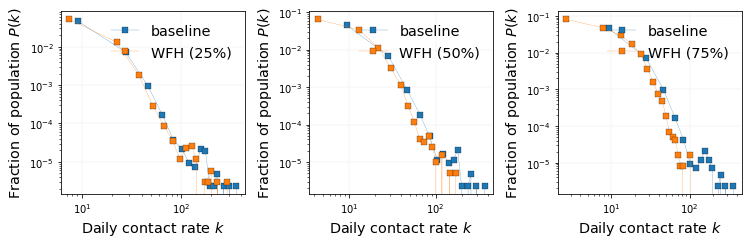

In [27]:
fgt=df_persons[df_persons['full_contacts']==1]['person_id_gt_s']
fgt=fgt.values

graphs=[]

# Results

#scale=1.25
#fig, ax=plt.subplots(tight_layout=True, figsize=(4*scale,3*scale))

scale=3.5
nrows=3
fig, axs=plt.subplots(tight_layout=True, ncols=nrows, figsize=(1*scale*nrows, 1*scale))

#for k, lab in zip(df,['baseline', 'pol-1-wfh', 'pol-2-wfh', 'pol-3-wfh', 'pol-1-sc', 'pol-2-sc', 'pol-3-sc']):
for k, lab, ax in zip(df[1:],['WFH (25%)', 'WFH (50%)', 'WFH (75%)'], axs.reshape(-1)):
    
    # ref
    G=run(df[0], df_persons)
    #graphs.append(G)

    a,b=np.histogram(G.get_total_degrees(G.get_vertices()[fgt]), 20, density=True)
    ax.loglog((b[1:]+b[:-1])/2, a, '-s', lw=0.25, label='baseline', mec='k', mew=0.25)
    
    
    
    
    # pol
    G=run(k, df_persons)
    graphs.append(G)

    a,b=np.histogram(G.get_total_degrees(G.get_vertices()[fgt]), 20, density=True)
    ax.loglog((b[1:]+b[:-1])/2, a, '-s', lw=0.25, label=lab, mec='k', mew=0.25)
    print(G.get_total_degrees(G.get_vertices()[fgt]).mean())


    ax.legend(fontsize='x-large', frameon=False, loc='best')
    ax.grid(True, lw=0.1)

    ax.set_xlabel(r'Daily contact rate $k$', fontsize='x-large')
    ax.set_ylabel(r'Fraction of population $P(k)$', fontsize='x-large')

fig.savefig('paper/policy1.jpg', bbox_inches='tight', dpi=400)

plt.show()

(0.0, 15.0)

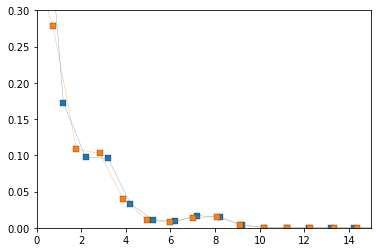

In [28]:
for k in range(2):
    a,b=np.histogram((graphs[k].ep['duration'].a)/3600, 20, density=True)
    plt.plot((b[1:]+b[:-1])/2, a, '-s', lw=0.25, label=lab, mec='k', mew=0.25)
    
plt.ylim(0,0.3)
plt.xlim(0,15)

In [29]:
for g, l in zip(graphs, ['wfh25', 'wfh50', 'wfh75']):
    print(np.round(2*g.num_edges()/g.num_vertices(),2))
    # g.save('sampled_contact_network_04_10_2022_'+l+'.xml.gz')

4.79
4.32
3.99


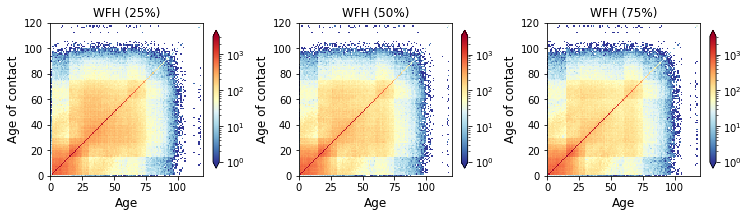

In [30]:
def get_contacts_fast(G, purpose=None):
    
    # issue with subsestting
    
#     if purpose==None:
#         e=G.get_edges()
#         print('nb of edges: ',e.shape)
#     else:
#         e=G.get_edges()
#         e=e[G.ep['purpose'].a==purpose]
#         print('nb of edges: ',e.shape)

    e=G.get_edges()
    
    v=G.get_vertices(vprops=[G.vp['age']])

    acp=np.vstack((v[e[:,0],1],v[e[:,1],1])).T
    #twins=acp[acp[:,0]==acp[:,1]]
    #others=acp[acp[:,0]!=acp[:,1]]

    
    #return np.vstack((twins,others,others[:,[1,0]]))
    #print(acp.shape)
    return np.vstack((acp,acp[:,[1,0]]))

def plot_results(purpose, G, ax, setting, ref):
    
    size_window=6.
    precision=1
    #purpose='household'

    #fig, ax=plt.subplots(figsize=(size_window,size_window), tight_layout=True)

    age_bins=np.arange(120/precision+1)*precision
    cmap = mpl.cm.get_cmap('RdYlBu_r').copy()
    cmap.set_bad(color='white', alpha=0.1)

    df_ascm=get_contacts_fast(G, purpose=purpose)
    pp=ax.hist2d(df_ascm[:,0],df_ascm[:,1], bins=age_bins, cmap=cmap, norm=mpl.colors.LogNorm(vmin=1))

    
    if setting==None:
        ax.set_title('Default', fontsize='large')
    else:
        ax.set_title(setting, fontsize='large')
    
    if ref in [0, 3]:
        ax.set_ylabel('Age of contact', fontsize='large')
    
    if ref in [3, 4, 6]:
        ax.set_xlabel('Age', fontsize='large')
        
    if ref==None:
        ax.set_ylabel('Age of contact', fontsize='large')
        ax.set_xlabel('Age', fontsize='large')
    
    ax.set_aspect('equal')
    #ax.set_title('{} layer'.format(purpose), fontsize='xx-large')
    
    cbar=fig.colorbar(pp[3], ax=ax, shrink=.6, extend='both')
    
    
    if ref in [2]:
        cbar.set_label('Frequency of contacts',fontsize='large',rotation=270, va='bottom')
    
    #fig.savefig('files/{}_weekday.pdf'.format(purpose), bbox_inches='tight')
    #fig.savefig('files/validation_4.jpg'.format(purpose), bbox_inches='tight', dpi=400)
    #plt.show()






scale=3.5
nrows=3
fig, axs=plt.subplots(tight_layout=True, ncols=nrows, figsize=(1*scale*nrows, 1*scale))

for ax, g, label in zip(axs.reshape(-1), graphs, ['WFH (25%)', 'WFH (50%)', 'WFH (75%)']):
    plot_results(None, g, ax, label, None)

fig.savefig('paper/policy2.jpg', bbox_inches='tight', dpi=400)

dfbp=pd.DataFrame([], columns=['age', 'degree', 'ref'])

for k in range(3):
    dfbp=dfbp.append(pd.DataFrame({'age': graphs[k].vp['age'].a[fgt], 'degree': graphs[k].get_total_degrees(graphs[k].get_vertices()[fgt]), 'ref': k}))
    
dfbp.to_csv('bp.csv', index=False)

In [31]:
len(graphs)

3

Text(0, 0.5, '# of engaged people')

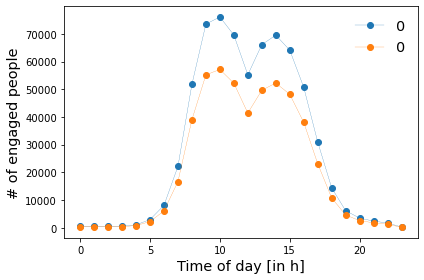

In [32]:
# diagnostics

def get_histograms_from_activities(dfc):
    bins=np.arange(25)
    dep=np.histogram(dfc['start_time']/3600, bins)
    arr=np.histogram(dfc['end_time']/3600, bins)
    return dep, arr

scale=.75
fig, ax =plt.subplots(tight_layout=True)


def plot_activities(df_activities, ax, color='b', which_act=0):
    for k in [0]:
        dfact_work=df_activities[df_activities['purpose'].isin([which_act])]

        dep, arr=get_histograms_from_activities(dfact_work)
        ax.plot(np.cumsum(dep[0])-np.cumsum(arr[0]), '-o',label=k, lw=0.25)

which_act=0

for k, lab in zip(df,[0, 0]):
    plot_activities(k, ax, 'b', which_act)
    #plot_activities(df_activities, ax, 'r', which_act)

ax.legend(fontsize='x-large', frameon=False, loc='best')
ax.set_xlabel('Time of day [in h]', fontsize='x-large')
ax.set_ylabel('# of engaged people', fontsize='x-large')

# fig.savefig('fig6.pdf', bbox_inches='tight')

In [33]:
# #f=(df_activities['end_time']-df_activities['start_time'])<0
# #A=df_activities[f]
# #A['end_time']=A['start_time']+A['end_time']
# #df_activities[f]['end_time']=A['end_time']

# plt.hist(graphs[0].ep['duration'].a, histtype='step', density=True)
# plt.hist(graphs[1].ep['duration'].a, histtype='step', density=True)

# plt.show()

In [ ]:
## SPATIAL CLUSTERING OF INDIVIDUALS
out=filter_by_location(df_activities_ref[['person_id_gt_s','location_id','start_time','end_time','purpose']].astype(int).values) 

In [ ]:
## NUMBER OF INVOLVED INDIVIDUALS / LAYER

status_layer=get_status(df_persons.shape[0], out)


number_of_agents_by_layer=np.count_nonzero(status_layer, axis=0)
number_of_agents_by_layer

In [ ]:
## SPATIAL DISTRIBUTION OF LOCATION SIZES

a,b=np.unique([np.unique(group[:,0]).shape[0] for group in out], return_counts=True)

fig, ax=plt.subplots(figsize=(2*4,3))
ax.plot([np.unique(group[:,0]).shape[0] for group in out], 'o', ms=2.)
plt.show()

In [ ]:
def to_contact_network(df_persons, list_of_contacts_in_HH):

    # COMBINING HOUSEHOLD AND NON-HOUSEHOLD CONTACTS
    # Add household-based contacts !

    #graph_household=load_graph('files/graph_weekday_household_all.xml.gz')

    graph_household=Graph(directed=False)
    graph_household.add_vertex(df_persons.shape[0])

    graph_household.vp['age'] = graph_household.new_vp('int', vals=df_persons.age.values.astype(int), val=None)
    #graph_household.vp['dep'] = graph_household.new_vp('int', vals=df_persons.numdep.values.astype(int), val=None)
    graph_household.vp['insee'] = graph_household.new_vp('int', vals=df_persons.hinsee.values.astype(int), val=None)

    graph_household.add_edge_list(list_of_contacts_in_HH)

    graph_household.edge_properties['p'] = graph_household.new_ep('int', vals=None, val=2000000)
    graph_household.edge_properties['purpose'] = graph_household.new_ep('int', vals=None, val=6)
    graph_household.edge_properties['duration'] = graph_household.new_ep('int', vals=None, val=10*60)
    
    return graph_household

graph_household=to_contact_network(df_persons, list_of_contacts_in_HH)

In [ ]:
def get_list_of_contacts_in_CC(out): 

    w=None
    parameters=np.array([[0.0048184 , 0.0207169 , 0.16349478],
                         [0.0207169 , 0.02147339, 0.        ],
                         [0.16349478, 0.        , 0.10746673]])


    #list_of_group_contacts=[] # To store the amount of contacts generated after filtering per space/time at location ID k
    list_of_contacts=[]

    sttm=time.time()

    loop_over=out

    with tqdm(total=len(loop_over), position=0, leave=True) as pbar: 
        for k in loop_over:
            if k.shape[0]>1:
                k_sorted=k[k[:, 2].argsort()]
                fo=get_contact_per_location(k_sorted[:,0:-1], parameters, w, k_sorted[:,-1], len(np.unique(k_sorted[:,0])))
                #list_of_group_contacts.append((len(np.unique(k_sorted[:,0])), len(fo))) # n_ij and E_ij
                list_of_contacts.extend(fo)
            pbar.update(1)

    print(time.time()-sttm)
    return list_of_contacts


#contacts_in_CC=get_list_of_contacts_in_CC(out)    

In [ ]:
def to_CCcontact_network(df_persons, list_of_CCcontacts, list_of_HHcontacts=None):     
    ## BUILD PHYSICAL CONTACT NETWORK
    # Here I build my contact network based on the list of edges previously computed

    print('Creating an undirected contact network of size ', df_persons.shape[0], ' nodes ...')

    start_time=time.time()

    setting_temporal_network=Graph(directed=False)
    setting_temporal_network.add_vertex(df_persons.shape[0])

    setting_temporal_network.vp['age'] = setting_temporal_network.new_vp('int', vals=df_persons.age.values.astype(int), val=None)
    #setting_temporal_network.vp['dep'] = setting_temporal_network.new_vp('int', vals=df_persons.numdep.values.astype(int), val=None)
    setting_temporal_network.vp['insee'] = setting_temporal_network.new_vp('int', vals=df_persons['hinsee'].values.astype(int), val=None)

    ppid = setting_temporal_network.new_ep('int')
    purpose = setting_temporal_network.new_ep('int')
    dur = setting_temporal_network.new_ep('int')

    #ppis = setting_temporal_network.new_ep('int')

    setting_temporal_network.edge_properties['duration'] = dur
    setting_temporal_network.edge_properties['purpose'] = purpose
    setting_temporal_network.edge_properties['p'] = ppid

    #setting_temporal_network.edge_properties['n'] = ppis

    print('Adding links ...')
    setting_temporal_network.add_edge_list(list_of_CCcontacts, eprops=[dur, purpose, ppid])

    print('contact network has {} egdes and {} vertices'.format(setting_temporal_network.num_edges(), setting_temporal_network.num_vertices()))
    print('Setting-based contact network estimated in ',time.time()-start_time, ' secs !')

    # setting_temporal_network.save("files/graph_weekday_complete.xml.gz")
    
    setting_temporal_network.add_edge_list(list_of_HHcontacts, eprops=[dur, purpose, ppid])
        
    return setting_temporal_network
        
        
#setting_temporal_network=to_CCcontact_network(df_persons, contacts_in_CC, list_of_HHcontacts=graph_household.get_edges([
#    graph_household.ep['duration'],
#    graph_household.ep['purpose'],
#    graph_household.ep['p']]))
    


In [ ]:
pol_degrees=setting_temporal_network.get_total_degrees(setting_temporal_network.get_vertices())

In [ ]:
#ref_degrees=setting_temporal_network.get_total_degrees(setting_temporal_network.get_vertices())

In [ ]:
fig, ax=plt.subplots()

a,b=np.histogram(pol_degrees, 20, density=True)
ax.loglog((b[1:]+b[:-1])/2, a, '-s', lw=0.25, label='baseline', mec='k', mew=0.25)

a,b=np.histogram(ref_degrees, 20, density=True)
ax.loglog((b[1:]+b[:-1])/2, a, '-s', lw=0.25, label='NPI', mec='k', mew=0.25)

ax.legend(fontsize='x-large', frameon=False)
ax.grid(True, lw=0.1)

ax.set_xlabel(r'Daily contact rate $k$', fontsize='x-large')
ax.set_ylabel(r'Fraction of population $P(k)$', fontsize='x-large')

In [ ]:
fig, ax=plt.subplots()

a,b=np.histogram(setting_temporal_network.ep['duration'].a[setting_temporal_network.ep['duration'].a>0], 20, density=True)
ax.loglog((b[1:]+b[:-1])/2, a, '-s', lw=0.25, label='baseline', mec='k', mew=0.25)

#a,b=np.histogram(ref_degrees, 20, density=True)
#ax.loglog((b[1:]+b[:-1])/2, a, '-s', lw=0.25, label='NPI', mec='k', mew=0.25)

ax.legend(fontsize='x-large', frameon=False)
ax.grid(True, lw=0.1)

ax.set_xlabel('Contact duration', fontsize='x-large')
ax.set_ylabel('Fraction contacts', fontsize='x-large')

In [ ]:
np.mean(ref_degrees)

In [ ]:
np.mean(pol_degrees)

In [ ]:
at=graph_household.get_edges([graph_household.ep['duration'], graph_household.ep['purpose'], graph_household.ep['p']]).T
ll=list(zip(at[0],at[1], at[2], at[3], at[4]))

In [ ]:
# To load the graph
# setting_temporal_network = load_graph("files/graphs/contact_network2.xml.gz")

In [ ]:
un, cn=np.unique(setting_temporal_network.ep['purpose'].a, return_counts=True)
print(un, cn)
plt.plot(cn)

In [ ]:
# setting_temporal_network.add_edge_list(graph_household.get_edges(eprops=[graph_household.ep['p'], graph_household.ep['purpose']]))

In [ ]:
plt.hist(setting_temporal_network.ep['purpose'].a)

In [ ]:
# PLOT AGE-SPECIFIC CONTACT MATRICES

#networks=[setting_temporal_network, graph_household]
#for label , gp in zip(['overall', 'household'], networks):
#    plot_results(label, gp)
    
#fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(2*4,4))
#ax1.plot()

In [ ]:
np.unique(setting_temporal_network.ep['purpose'].a)

In [ ]:
# POST-PROCESSING

def get_contacts_fast(G, purpose=None):
    
    # issue with subsestting
    
#     if purpose==None:
#         e=G.get_edges()
#         print('nb of edges: ',e.shape)
#     else:
#         e=G.get_edges()
#         e=e[G.ep['purpose'].a==purpose]
#         print('nb of edges: ',e.shape)

    e=G.get_edges()
    
    v=G.get_vertices(vprops=[G.vp['age']])

    acp=np.vstack((v[e[:,0],1],v[e[:,1],1])).T
    #twins=acp[acp[:,0]==acp[:,1]]
    #others=acp[acp[:,0]!=acp[:,1]]

    
    #return np.vstack((twins,others,others[:,[1,0]]))
    #print(acp.shape)
    return np.vstack((acp,acp[:,[1,0]]))

def plot_results(purpose, G, ax, setting, ref):
    
    size_window=6.
    precision=1
    #purpose='household'

    #fig, ax=plt.subplots(figsize=(size_window,size_window), tight_layout=True)

    age_bins=np.arange(120/precision+1)*precision
    cmap = mpl.cm.get_cmap('RdYlBu_r').copy()
    cmap.set_bad(color='white', alpha=0.1)

    df_ascm=get_contacts_fast(G, purpose=purpose)
    pp=ax.hist2d(df_ascm[:,0],df_ascm[:,1], bins=age_bins, cmap=cmap, norm=mpl.colors.LogNorm(vmin=1))

    
    if setting==None:
        ax.set_title('Default', fontsize='large')
    else:
        ax.set_title(setting, fontsize='large')
    
    if ref in [0, 3]:
        ax.set_ylabel('Age of contact', fontsize='large')
    
    if ref in [3, 4, 6]:
        ax.set_xlabel('Age', fontsize='large')
        
    if ref==None:
        ax.set_ylabel('Age of contact', fontsize='large')
        ax.set_xlabel('Age', fontsize='large')
    
    ax.set_aspect('equal')
    #ax.set_title('{} layer'.format(purpose), fontsize='xx-large')
    
    cbar=fig.colorbar(pp[3], ax=ax, shrink=.6, extend='both')
    
    
    if ref in [2]:
        cbar.set_label('Frequency of contacts',fontsize='large',rotation=270, va='bottom')
    
    #fig.savefig('files/{}_weekday.pdf'.format(purpose), bbox_inches='tight')
    #fig.savefig('files/validation_4.jpg'.format(purpose), bbox_inches='tight', dpi=400)
    #plt.show()

In [ ]:
#setting_temporal_network.save("files/graphs/contact_network1.xml.gz")